##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [ ]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland'):
#         self.Rule = Rule
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
#             self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_'+AltPath+'.csv',delimiter = ',',header = 0,index_col=[0])
#             self.params['Dpath'] += AltPath+'/'+target+'/'
            
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'
        
            
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        
        print()
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
#         self.Best = self.Best.loc[self.Best['Size']==self.Best['Size'].min()]
#         self.Best = self.Best.loc[self.Best['MSE']==self.Best['MSE'].min()]
#         self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
            
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
#         print()
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
#         pool = Pool(processes=1,maxtasksperchild=75) 
#         for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):

        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
#             self.Model=results[1]
#             YVar = self.RST.YvarScaled.inverse_transform(YVar)    
            YVar = YStandard.inverse_transform(YVar)                    
#         pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     
    # print(fch4.RST.X_fill.shape)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        #         temp=open(Path+f+'_Removed.txt', "r")
        #         AllRes[f]['Removed'] = temp.read().split(',')
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
#         for filename in os.listdir(Path):
#             if filename.endswith(".npy") and filename.split('.')[0].split('_')[0]==f:
# #                 print(filename)
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]={}
#                 AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[2])]\
#                 [int(filename.split('.')[0].split('_')[-1])]=np.load(Path+filename)
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)


Variables=['H','LE','fco2','fch4',
           'wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg',
           'PPFD_Avg',
           'Table_1','Temp_2_5_1','Temp_2_5_2','Temp_5_1',
           'Temp_5_2','Temp_15_1','Temp_15_2','Ts All Cent',
           'Ts All Rim','VWC_2','VWC_1','Active_Layer_1','24H Rain',
           'wind_dir','ER','Time','DOY',
           'VPD','u*','Wind_Direction','Delta_Table_1',
           'Rolling_Temp_15_1','Delta_air_pressure','Anoxic_Depth','Ratio',
           'Active_Layer_2','Rolling_NR_Wm2_Avg',
              'Rim','Collapse','Polygon','Daytime']
Aliases=['H','LE','F_{CO2}','F_{CH4}',
         'U','Pa','T$_{a}$','Rn',
         'PPFD',
         'W$_{TD}$','T$_{Poly 2.5}$','T$_{Rim 2.5}$','T$_{Ply 5}$',
         'T$_{Rim 5}$','T$_{Ply 15}$','T$_{Rim 15}$','Ts All Cent',
         'Ts All Rim','VWC$_{Rim}$','VWC$_{Ply}$','AL','24H Rain','Dir','ER','Time','DOY','VPD','u$^*$','Wind Dir','DW$_{TD}$',
         'Mean T$_{s 15 cm Poly}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'F$_{Rim}$','F$_{Tro}$','F$_{Ply}$','Daytime']
NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n
    

In [373]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
# Site = 'FishIsland_Best/'
Site = 'FishIsland/'
Path = Path+Site
AllRes = RecRead(Path = Path)


F = 'fco2'
# F = 'fch4'

ch4_Model_Index = '10_13'
# ch4_Model_Index = '9_15'
# ch4_Model_Index = '7_19'
ch4_Model_Index = '6_21'
# ch4_Model_Index = '5_25'

co2_Model_Index = '5_37'
# co2_Model_Index = '4_45'

if F == 'fch4':
    Model_Index = ch4_Model_Index

if F == 'fco2':
    Model_Index = co2_Model_Index
    

<IPython.core.display.Javascript object>


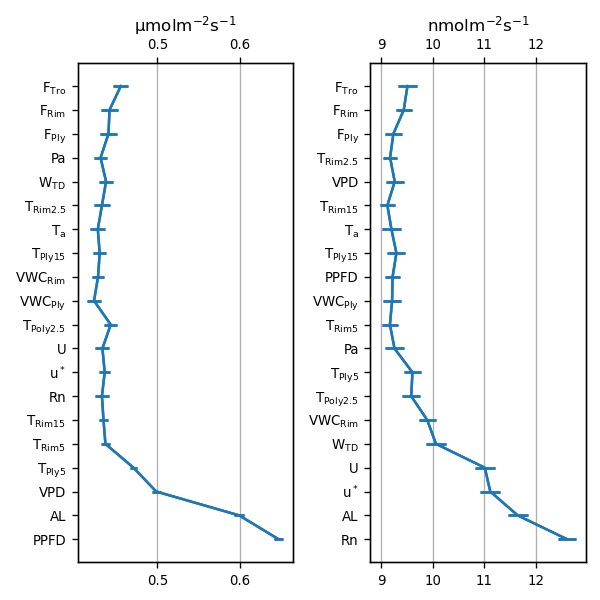

Index(['Model', 'Size', 'Nodes', 'MSE', 'RMSE', 'SE', 'r2', 'Performance', 'K',
       'Thresh', 'Remove'],
      dtype='object')
           RMSE        SE       MBE     MBESE        R2
20_10  0.455674  0.004580  0.000065  0.003661  0.906947
19_11  0.441992  0.004881  0.000343  0.002460  0.912451
18_11  0.440712  0.004841  0.000536  0.002224  0.912958
17_12  0.431123  0.003955 -0.001535  0.002980  0.916704
16_13  0.437786  0.004206  0.001916  0.002804  0.914110
15_14  0.432801  0.004834 -0.002437  0.003495  0.916055
14_15  0.427755  0.004566  0.001047  0.003201  0.918001
13_16  0.430046  0.003896 -0.004096  0.002474  0.917120
12_17  0.428030  0.003536 -0.003905  0.002581  0.917895
11_18  0.423188  0.003923  0.003860  0.002247  0.919742
10_20  0.443433  0.003717  0.002176  0.002936  0.911880
9_22   0.433365  0.004154 -0.000611  0.002367  0.915836
8_25   0.436133  0.003286  0.003174  0.003061  0.914757
7_28   0.432784  0.003954  0.003382  0.002682  0.916061
6_32   0.434658  0.002945  0.0

In [378]:
fig,ax = plt.subplots(1,2,figsize=(5,5))

for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    print(Records.columns)
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
    #     print(I)

        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()
        # print(df)
        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())


    #     print('MBE: ',(df['y']-df['target']).sum()/df['y'].count())
        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

#     RMSE=np.array(RMSE)
    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(30**.5),'MBE':MBE,'MBESE':MBEs/(30**.5),'R2':r2})
    Xlbls = []
    for v in Records.Remove:
#         print(v)
        Xlbls.append(NameDict[v])
    print(df)
    df = df.iloc[::-1]
    print(df)
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    print(df.loc[df['RMSE']<=Mn['RMSE'].values[0]+Mn['SE'].values[0]])
    # plt.plot([df.index[0],df.index[-1]],[Mn['RMSE']+Mn['SE']*2.04,Mn['RMSE']+Mn['SE']*2.04],color='r')
    x2 = ax[i].twiny()
    
#     x2.errorbar(Xlbls,df['MBE'],yerr=df['MBESE'],color='r')
#     ax[i].set_ylim(0,1)
#     x2.plot(df['R2'],Xlbls[::-1],color='r')
#     x2.set_xlim(0,1)
    ax[i].errorbar(df['RMSE'],Xlbls[::-1],xerr=df['SE']*2.04)
    x2.errorbar(df['RMSE'],Xlbls[::-1],xerr=df['SE']*2.04)
    ax[i].grid(axis='x')
    if F == 'fco2':
        lbl ='${\mu}mol m^{-2} s^{-1}$'
    else:
        lbl = '$nmol m^{-2} s^{-1}$'
    x2.set_xlabel(lbl)
    
#     ax[i].tick_params(axis='x', rotation=90)
#     ax[i].set_zorder(x2.get_zorder()+1)
#     ax[i].patch.set_visible(False)
plt.tight_layout()

0.4352101181303685 0.009505113581272647
0.9151619405440359 0.001660335624391677


<IPython.core.display.Javascript object>


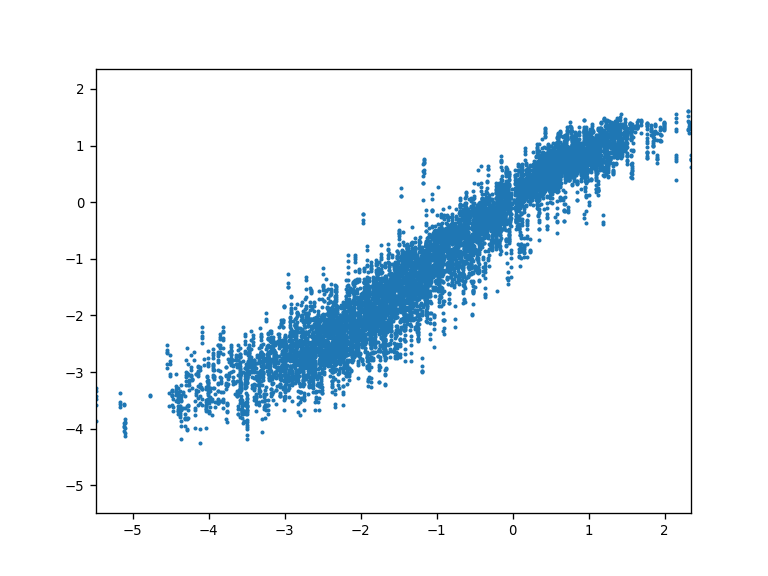

MBE:  0.003559050168799412
SDev:  0.4573813239710854
RMSE:  0.43546655628460573
r2:  0.9152004641579674


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


<IPython.core.display.Javascript object>


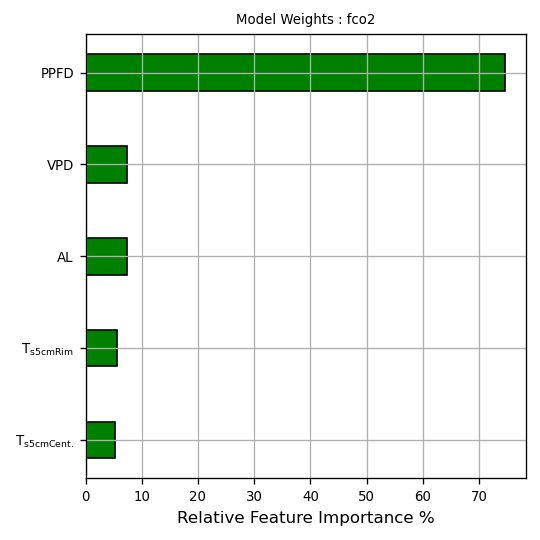

          Factors  RC_Sum: 5_37    Cumsum
0        Temp_5_1      0.052066  1.000000
1        Temp_5_2      0.056104  0.947934
2  Active_Layer_1      0.073038  0.891831
3             VPD      0.073198  0.818793
4        PPFD_Avg      0.745595  0.745595
['Temp_5_1' 'Temp_5_2' 'Active_Layer_1' 'VPD' 'PPFD_Avg']


In [226]:

# Model_Index = None
if Model_Index == None:
    Best = Records.loc[Records['Size']==Records['Size'].min()]
else:
    Best = Records.loc[Records.index==Model_Index]    
# Min = Records.loc[Records['MSE']==Records['MSE'].min()]
# Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
# Best = Best.loc[Best['Size']==Best['Size'].min()]

Size = Best.Size.values[0]
Nodes = Best.Nodes.values[0]
# N = Records.Size.max()
Records['RMSE']=Records['MSE']**.5
Records['RSE']=Records['SE']**.5
# print(Size)
# print(Records)

# print(Records['Model'].values[0].split('+'))

Best_U = 'RC_Sum: '+Best.index.values[0]
# print(Best_U)

RMSE=[]
R2=[]
# plt.figure()

y = np.load(Path+F+'_Yhat_'+Best.index.values[0]+'.npy')#.mean(axis=0)
x = np.load(Path+F+'_Ytrue_'+Best.index.values[0]+'.npy')#.mean(axis=0)
for i in range(y.shape[0]):
    df = pd.DataFrame(data={'target':y[i],'y':x[i]}).dropna()
    rmse = metrics.mean_squared_error(df['y'],df['target'])**.5
    r2 = metrics.r2_score(df['y'],df['target'])
    RMSE.append(rmse)
    R2.append(r2)
    
RMSE,R2=np.array(RMSE),np.array(R2)

print(RMSE.mean(),RMSE.std()/RMSE.shape[0]**.5*stats.t.ppf(0.975,RMSE.shape[0]))#,RMSE.count())
print(R2.mean(),R2.std()/R2.shape[0]**.5)#,R2.count())

plt.figure()
df = pd.DataFrame(data={'target':np.nanmean(y,axis=0),'y':np.nanmean(x,axis=0)})
df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()
plt.scatter(df['y'],df['target'],s=2)#(AllRes['fch4'].keys())
plt.xlim(df['y'].min(),df['y'].max())
plt.ylim(df['y'].min(),df['y'].max())

print('MBE: ',(df['y']-df['target']).sum()/df['y'].count())
print('SDev: ',np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
print('RMSE: ',metrics.mean_squared_error(df['y'],df['target'])**.5)
print('r2: ',metrics.r2_score(df['y'],df['target']))

RMSE = np.array(RMSE)
rmse = RMSE.mean()
SE = ((RMSE-rmse)**2).sum()/(y.shape[0])**.5
Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
Mean = Derivatives.mean(axis=0)
Std = Derivatives.std(axis=0)
X = np.load(Path+F+'_X_'+str(Size)+'.npy')

Deriv_Labels= DerivKeys(Results,Best_U)
SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

fig,ax=plt.subplots(figsize=(4.5,4.5))
ax.barh(SubSet.index,SubSet[Best_U]*100,#xerr=SubSet[Best_SE]*100,
         height=.4,color='g',edgecolor='k')
SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
print(SubSet[['Factors',Best_U,'Cumsum']])
print(SubSet['Factors'].values)
ax.set_yticks(SubSet.index)
ax.set_yticklabels([NameDict[v] for v in SubSet['Factors'].values])

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Model Weights : '+F)
ax.grid()
plt.tight_layout()
plt.savefig('PAD_'+F+'_PrunedFactors.png')

NR_Wm2_Avg 0.6643837498249299
u* 0.6761072696052501
Active_Layer_1 -0.39751917305081114
wind_speed -0.5647253842032487
Table_1 0.3172244875616063
Temp_5_1 -0.38147880222861563
VWC_2 -0.24930758967718084
Temp_2_5_1 0.36313929129796185
air_pressure -0.11597766559203936


<IPython.core.display.Javascript object>


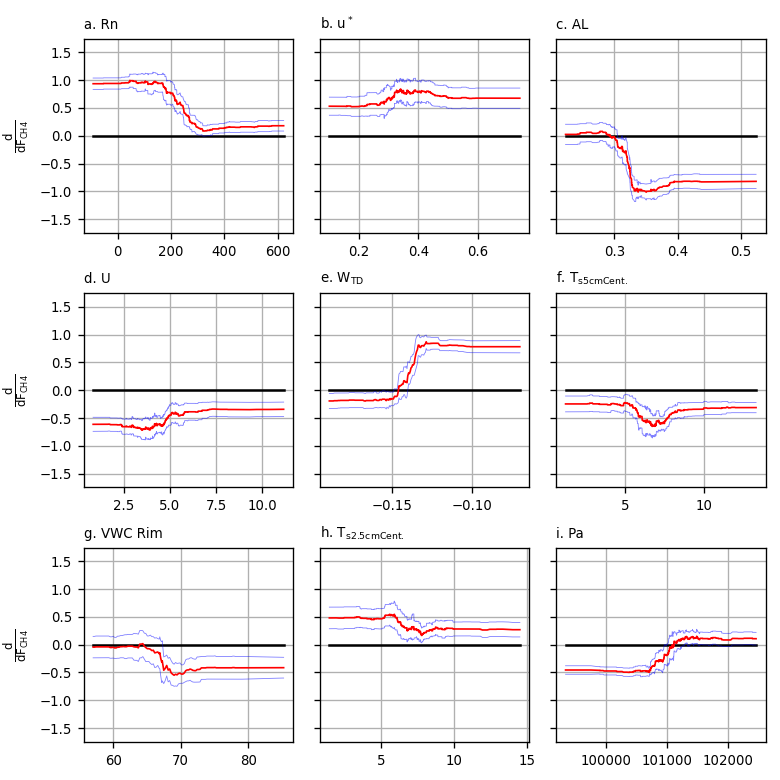

0 NR_Wm2_Avg
1 u*
2 Active_Layer_1
3 wind_speed
4 Table_1
5 Temp_5_1
6 VWC_2
7 Temp_2_5_1
8 air_pressure
             Vars
0      NR_Wm2_Avg
1              u*
2  Active_Layer_1
3      wind_speed
4         Table_1
5        Temp_5_1
6           VWC_2
7      Temp_2_5_1
8    air_pressure


In [205]:
Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
import math
from string import ascii_lowercase
df = pd.DataFrame(data={'Vars':Vars})
rsmp = 50
for Var in Vars:
    i=Deriv_Labels[Var]
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
    Temp=Temp.sort_values(by='X').reset_index()
    print(Var, Temp['Y'].mean())
C=3
R=math.ceil(len(Vars)/C)

fig = plt.figure(figsize=(6.5,6.5))
gs = fig.add_gridspec(R,C)
r,c=0,0
for j,Var in enumerate(Vars):
    print(j,Var)
    if c == C:
        c = 0
        r+=1
    i=Deriv_Labels[Var]
    if c == 0:
        ax1 = fig.add_subplot(gs[r, c])#,sharex=ax2)
        ax1.set_ylabel(r'$\frac{d}{d'+NameDict[F]+'}$')
    else:
        ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
        plt.setp(ax1.get_yticklabels(), visible=False)
    p = Derivatives.shape[0]
    ax1.plot([X[:,i].min(),X[:,i].max()],[0,0],color='k')
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i]+Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='b',alpha=.5,linewidth=.5)
    Min = Derivatives.min(axis=0)
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i]-Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='b',alpha=.5,linewidth=.5)
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=1)
    if F!='fco2':
        ax1.set_ylim(-1.75,1.75)
    else:
        ax1.set_ylim(-3,1)
    ax1.grid()
    ax1.set_title(ascii_lowercase[j]+'. '+NameDict[Var],loc='left')
    c+=1
plt.tight_layout()
plt.savefig(F+'Derivatives.png')
print(df)




count    3788.000000
mean        0.078683
std         0.023950
min         0.008631
25%         0.072343
50%         0.079272
75%         0.085474
max         1.241036
Name: ratio, dtype: float64


<IPython.core.display.Javascript object>


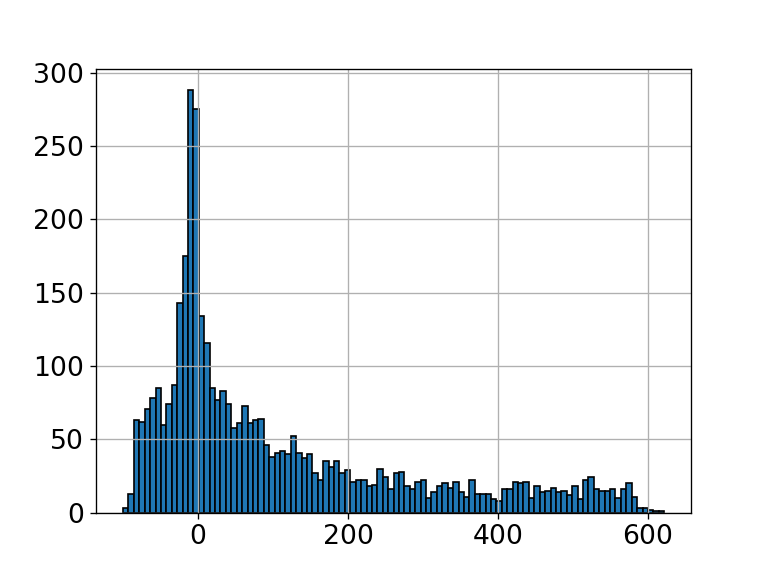

datetime
2017-06-30 00:00:00-06:00    11.273167
2017-07-31 00:00:00-06:00    11.789662
2017-08-31 00:00:00-06:00    11.376217
2017-09-30 00:00:00-06:00     5.583648
Freq: M, Name: AirTC_Avg, dtype: float64
10.63507435701553
174
256
10.60077594643316
99.6


In [164]:

# Site='FishIsland_Best'

SE_Rule=100

Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName='AllData.csv',Site=Site)#,AltPath='Test')
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site)#,AltPath='Test')
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName='AllData.csv',Site=Site,AltPath='fco2')
T30 = fco2.RST.Master.copy()
# T30.loc[T30['u*']>.8,'u*']=np.nan
# T30 = Mapper(T30,fch4,'NME_est',Fill = False)
# T30 = Mapper(T30,fco2,'NEE_est',Fill = False)


if F == 'fch4':
    target = fch4
    Name = 'NME_'
else:
    Name = 'NEE_'
    target = fco2
    
T30['ratio'] = T30['u*']/T30['wind_speed']
print(T30['ratio'].describe())
    
# plt.figure()
# T30['ratio'].hist(bins=20,edgecolor='k')
# plt.figure()
# T30['wind_speed'].hist(bins=20,edgecolor='k')
# plt.figure()
# T30['Diff_H']=T30['Temp_5_2']-T30['Temp_5_1']
# T30['Diff_V']=T30['Temp_5_2']-T30['Temp_15_1']
# (T30['Diff_H']).hist(bins=20,edgecolor='k')
# plt.figure()
# (T30['Diff_V']).hist(bins=20,edgecolor='k')


plt.figure()
(T30['NR_Wm2_Avg']).hist(bins=100,edgecolor='k')
print(T30['AirTC_Avg'].resample('M').mean())
print(T30['AirTC_Avg'].mean())
print(T30['DOY'].min())
print(T30['DOY'].max())


Temp = T30.loc[((T30['DOY']>T30['DOY'].min())&(T30['DOY']<T30['DOY'].max()))]

print(Temp['AirTC_Avg'].mean())
print(Temp['Rain_mm_Tot'].sum())
# print(T30.loc[T30['Active_Layer_1']>])

       25%  50%  75%  Collapse  Disturbed  FarField  Polygon  Rim  count  max  \
count  NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
mean   NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
std    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
min    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
25%    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
50%    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
75%    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   
max    NaN  NaN  NaN       NaN        NaN       NaN      NaN  NaN    NaN  NaN   

       mean  min  std  
count   NaN  NaN  NaN  
mean    NaN  NaN  NaN  
std     NaN  NaN  NaN  
min     NaN  NaN  NaN  
25%     NaN  NaN  NaN  
50%     NaN  NaN  NaN  
75%     NaN  NaN  NaN  
max     NaN  NaN  NaN  
        Polygon       Rim  Collapse  FarField  Disturb

<IPython.core.display.Javascript object>


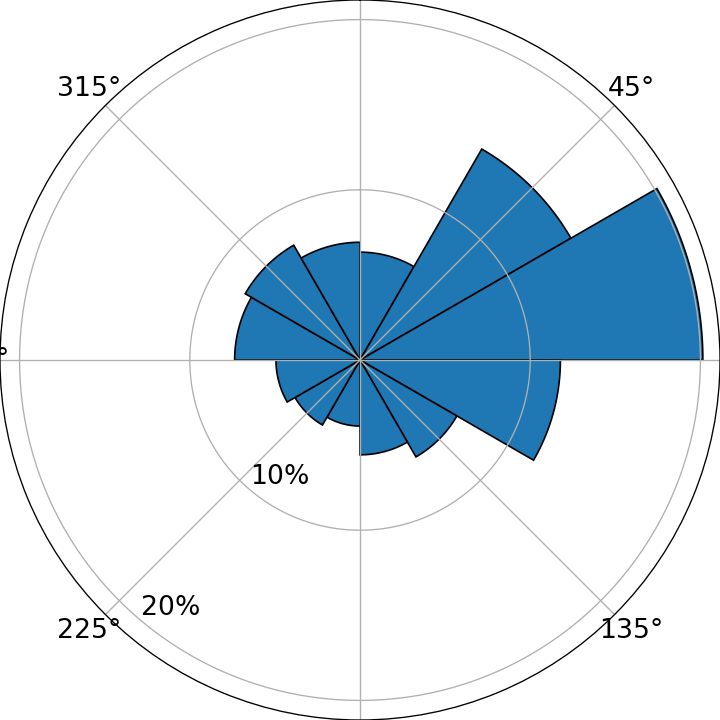

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [162]:
Temp = (T30.loc[np.isnan(T30['ch4_flux'])==False,['Polygon', 'Rim', 'Collapse','FarField','Disturbed']].describe().round(3))
print(Temp)

Temp2 = (T30.loc[np.isnan(T30['co2_flux'])==False,['Polygon', 'Rim', 'Collapse','FarField','Disturbed']].describe().round(3))
print(Temp2)

print(Temp - Temp2)
# print(T30['Wind_Direction'])
# print(T30.columns.values)
# print(T30['Dir'].sort_values().unique())
Sectors = T30.groupby('Dir').count()['u*']
print(Sectors/Sectors.sum())

SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


f = plt.figure(figsize=(6,6))

ax2 = f.add_axes([0.0, 0, 1, 1], polar=True)
# # print(Wind_Groups_median.index,)
ax2.bar(Sectors.index*np.pi/180,Sectors/Sectors.sum()*100,
#         label = 'Data Zo',
        width=30*np.pi/180,edgecolor='k')
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([10,20])
ax2.set_yticklabels(['10%','20%'])
ax2.set_rlabel_position(220)
plt.tight_layout()
plt.savefig('Wind_rose.png')#,transparent=True)
# for d in Wind_Groups_median.index:
#     Data.loc[Data['Dir']==d,'Zo']=Wind_Groups_median.loc[d]['Z0']
# print(Data['Z0'].count()/Data['AirTC_Avg'].count())


In [94]:

N = 30
print(target.Model_Selection)
# T30['Ratio']=T30['u*']/T30['wind_speed']
IP = target.Model_Selection.split('+')
print(IP)
for a in 'fch4','fco2':
    IP.append(a)
List = []
print(IP)
print(T30[IP].corr())


if F == 'fco2':
    A=['PPFD_Avg']
    B=['Active_Layer_1']
    C=[['NR_Wm2_Avg','VPD'],[],[],[]]
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]
else:
    A=['wind_speed']
    B=['u*']
    C=[[],[],[],[]]
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]

for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(A,B,C,D,Z,V):

    Temp = T30[IP].dropna()
    if Avar == 'PPFD_Avg':
        o = 1
    else:
        o = 0
    A = np.array([Temp[Avar].quantile(n/N) for n in range(N+1)])
    if Bvar == 'Active_Layer_1':
        B = np.array([.25,.35,.45])
    print(B)

    Av2,Bv2=np.meshgrid(A,B)
    Av2,Iv2=np.meshgrid(A,B)
    Iv = Iv2.flatten()
    
    Av,Bv=Av2.flatten(),Bv2.flatten()


    Temp = Temp[0:Av.shape[0]]*0+Temp.median()

    Temp[Avar]=Av
    Temp[Bvar]=Bv
    Temp['Class']=Iv

    for cvar in Cvar:
        A = T30[[Avar,cvar]].dropna()
        Lr = scipy.stats.linregress(A[Avar],A[cvar])
        print(Lr)
        Cv=(Av*Lr[0]+1)+Lr[1]
        Temp[cvar]=Cv
    for dvar in Dvar:
        A = T30[[Bvar,dvar]].dropna()
        Lr = scipy.stats.linregress(A[Bvar],A[dvar])
        print(Lr)
        Dv=Bv*Lr[0]+Lr[1]
        Temp[dvar]=Dv
    for z,v in zip(Zero,Val):
        Temp[z]=v

    Temp = Mapper(Temp,target,Name,Fill = False)
    List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])

VPD+PPFD_Avg+Active_Layer_1+Temp_5_2
['VPD', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_2']
['VPD', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_2', 'fch4', 'fco2']
                     VPD  PPFD_Avg  Active_Layer_1  Temp_5_2      fch4  \
VPD             1.000000  0.662297       -0.299374  0.596994  0.289968   
PPFD_Avg        0.662297  1.000000       -0.337556  0.495307  0.597840   
Active_Layer_1 -0.299374 -0.337556        1.000000 -0.391446 -0.270007   
Temp_5_2        0.596994  0.495307       -0.391446  1.000000  0.250719   
fch4            0.289968  0.597840       -0.270007  0.250719  1.000000   
fco2           -0.435613 -0.785319        0.202152 -0.341372 -0.637972   

                    fco2  
VPD            -0.435613  
PPFD_Avg       -0.785319  
Active_Layer_1  0.202152  
Temp_5_2       -0.341372  
fch4           -0.637972  
fco2            1.000000  
[0.25 0.35 0.45]
LinregressResult(slope=0.4305486232782319, intercept=-34.66803001179993, rvalue=0.9807483680157544, pvalue=0.0, stderr=0.0

FloatProgress(value=0.0, description='Running:', max=12.0)

In [95]:
print(T30.loc[T30['Active_Layer_1']<=.25,'PPFD_Avg'].min())

10.51


<IPython.core.display.Javascript object>


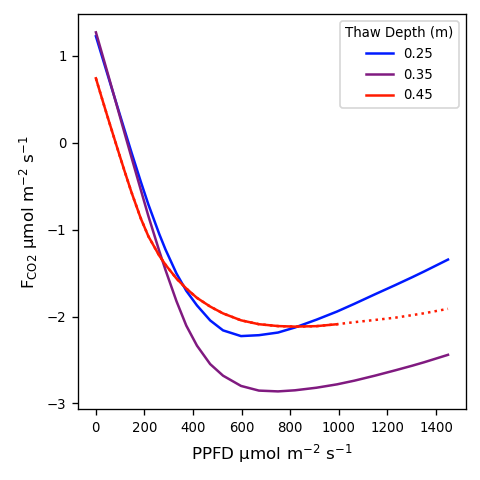

<IPython.core.display.Javascript object>


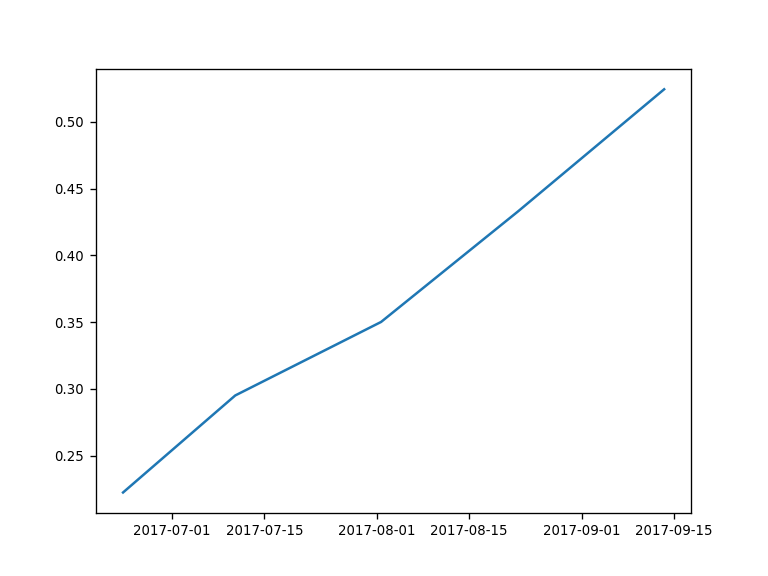

In [96]:
plt.figure(figsize=(4,4))
l = 0
Rec = List[l][0]
A = List[l][1]
B = List[l][2]


# print(Rec[B].unique())
i = 0
L = Rec['Class'].unique().shape[0]-1
# i+=L
# L*=2
for v in Rec['Class'].unique():
    Temp = Rec.loc[Rec['Class']==v]
    if v== .45:
        TempA = Temp.loc[Temp[A]<1055]
#         TempB = Temp.loc[Temp[A]>1055]
        plt.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
        plt.plot(TempA[A],TempA[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
    else:
        plt.plot(Temp[A],Temp[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
    i +=1
    
    
plt.ylabel(r'$F_{CO2}\ {\mu}mol\ m^{-2}\ s^{-1}$')
plt.xlabel(r'$PPFD\  {\mu}mol\ m^{-2}\ s^{-1}$')
# plt.xlabel(r'Primary T$_{\rm eff}$')
# plt.legend(title=r'u* % of $\bar{U}$')
plt.legend(title='Thaw Depth (m)')
# plt.figure()
# plt.scatter(Rec[A],Rec[B])
plt.tight_layout()
plt.savefig(F+'_Plot.png')

plt.figure()
plt.plot(T30.index,T30['Active_Layer_1'])


In [172]:
# # plt.figure()



# plt.figure()        
# u='Temp_15_1'
# w='Table_1'

# # print((Lr[1]-Lr[1]*.1),)
# A = T30[[u,w]].dropna()

# # print((Lr[1]+Lr[1]*.1),)
# Lr = scipy.stats.linregress(A[w],A[u])
# plt.scatter(T30[w],T30[u],c=T30['ch4_flux'])#.rolling(48).mean(),s=10)
# # plt.plot(T30[w],T30[w]*(Lr[0])+Lr[1]+Lr[1]*10,color='r')
# # plt.plot(T30[w],T30[w]*(Lr[0])+Lr[1]+Lr[1]*-10,color='r')
# plt.plot(T30[w],T30[w]*(Lr[0])+Lr[1],color='b')
# print(T30.loc[T30['VPD']<100,'PPFD_Avg'].max())


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [165]:

mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':(1e-6 * 12.0107 *1800),
        'fch4':(1e-9 * 12.0107 *1800)
       }
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)


T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0

T30_Dark['NR_Wm2_Avg'] = T30.loc[T30['PPFD_Avg']<10,'NR_Wm2_Avg'].min()
T30_Dark['VPD'] = 0#T30.loc[T30['PPFD_Avg']<10,'VPD'].min()
# T30_Dark = T30_Dark.resample('D').mean()

T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)




fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'VWC_2', 'Active_Layer_1'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/6_21/


FloatProgress(value=0.0, description='Running:', max=12.0)

fco2 ['VPD', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_2'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/4_45/


FloatProgress(value=0.0, description='Running:', max=12.0)

ER ['VPD', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_2'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/4_45/


FloatProgress(value=0.0, description='Running:', max=12.0)

In [166]:
for target,name in zip([fch4,fco2,ER],['NME','NEE','ER']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est','ER_est']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
print(T30['ER_est'].mean())
print(T30['NEE_est'].mean())
print(T30['ER'].mean())
print(T30['NEE'].mean())

NME
NEE
ER
Done
Done
1.0948878526687622
-0.6152151823043823
0.023495676801911357
-0.013325551570619945


In [167]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)



# 1e-6 * 44.0095 *3600,1e-3 * 16.04246 *3600

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'NME':fch4,
           'NEE_est':fco2,
           'NME_est':fch4,
           'ER_est':ER,
           'ER':ER}
for Var in ['NEE',
            'NME',
            'ER']:#,
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5*48*mult[target.target]
#         print((std/Temp.shape[0]**.5)*48*mult[target.target]*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*48
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/48)#*mult[target.target]
    print(Temp[Var].sum(),(Temp.shape[0]/48),U)
    print()
#     if target == 'ER':
#         U*= mult[target.target]
    Estimates.append(U)
    CIs.append(Int)

    Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
    
std = MI(Temp,Cols)**.5
Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
print(Temp['CBal'].mean()*48,Int*48)
    
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
# print(Data)
# print(T30[['fch4','NME_est']].mean()*mult['fch4']*48)
# print(T30[['fco2','NEE_est']].mean()*mult['fco2']*48)

# T30['C']

# print(T30[['NME']].mean().values[0]*mult['fch4']*48*1e-3*+T30[['NEE']].mean().values[0]*mult['fco2']*48)
print(Estimates[0]+Estimates[1])



All = pd.DataFrame(data = Data)
print(All.iloc[0]['Estimates']+All.iloc[1]['Estimates'])



print(T30['fco2'].mean(),T30['NEE'].mean())
print(T30['ER'].mean(),T30['ER_est'].mean())


UgConv_CO2=1/12.01*44.01/24/3600*1e6
UgConv_CH4=1/12.01*16.01/24/3600*1e6

print(All['Estimates']*UgConv_CO2)
print(All['Estimates'].iloc[0]-All['Estimates'].iloc[2])
print(All['Estimates'].iloc[0]-All['Estimates'].iloc[2]*UgConv_CO2)

All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
# print(ER_fixed.Best)




-52.39606877567762 81.91666666666667 -0.6396264753897573

2.589596520943978 81.91666666666667 0.031612571974901055

92.38500118511574 81.91666666666667 1.1277924864917486

-0.6080139034148553 0.04590948035366814
-0.6080139034148562
-0.6080139034148562
-0.9051653347292902 -0.013325551570619945
0.023495676801911357 1.0948878526687622
0   -27.128204
1     1.340771
2    47.832581
Name: Estimates, dtype: float64
-1.7674189618815057
-48.47220747511785


,Flux,Type,Scale,Estimates,SE,95% CI/PI
0,NEE,EC Obs.,Footprint,-0.639626,1.424091,0.044526
1,NME,EC Obs.,Footprint,0.031613,0.013306,0.000416
2,ER,EC Obs.,Footprint,1.127792,0.314244,0.009825


<IPython.core.display.Javascript object>


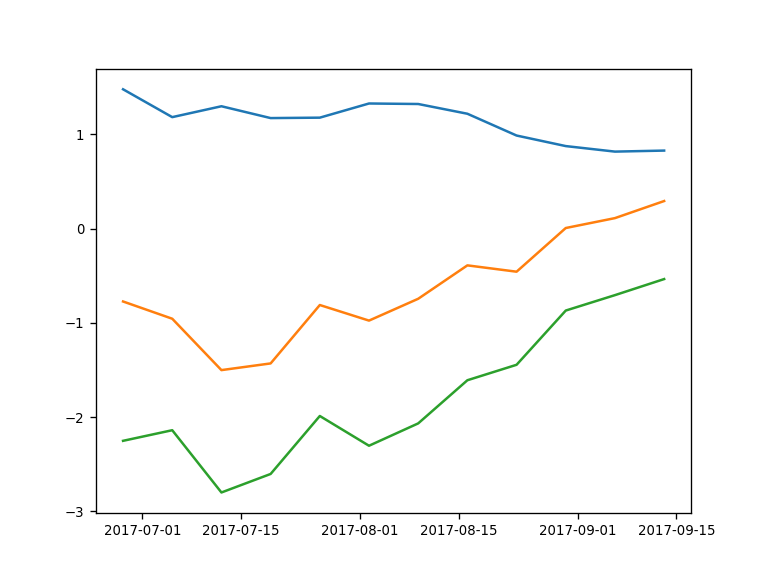

52.778220523595806
-60.727703472375865
-113.50600793838501
datetime
2017-06-30 00:00:00-06:00   -0.903762
2017-07-31 00:00:00-06:00   -1.140566
2017-08-31 00:00:00-06:00   -0.406389
2017-09-30 00:00:00-06:00    0.185244
Freq: M, Name: NEE_est, dtype: float32
datetime
2017-06-30 00:00:00-06:00    35.349861
2017-07-31 00:00:00-06:00    39.515755
2017-08-31 00:00:00-06:00    26.913128
2017-09-30 00:00:00-06:00    21.351599
Freq: M, Name: NME_est, dtype: float32


In [173]:


GWPmult = {'fco2':(1e-6 * 44.01 *1800*12.01/44.01),
        'fch4':(1e-9 * 16.04 *1800*28*12.01/44.01)
       }

T30['NME_GWP']=T30['NME']/mult['fch4']*GWPmult['fch4']
# print(T30['NME_est'].mean())

# print(T30['co2_flux'].mean())
T30['NEE_GWP']=T30['NEE']/mult['fco2']*GWPmult['fco2']



plt.figure()
plt.plot(T30['ER_est'].resample('W-Wed').mean()*mult['fco2']*48)
plt.plot(T30['NEE_est'].resample('W-Wed').mean()*mult['fco2']*48)
plt.plot(T30['NEE_est'].resample('W-Wed').mean()*mult['fco2']*48-T30['ER_est'].resample('W-Wed').mean()*mult['fco2']*48)
# plt.plot(T30['NEE'].resample('W-Wed').mean())

Temp = T30.loc[(T30.Time>9)&(T30.Time<21)]
print(Temp['ER_est'].mean()*44.01)
print(Temp['NEE_est'].mean()*44.01)
print((Temp['NEE_est']-Temp['ER_est']).mean()*44.01)
# print(.mean()*mult['fco2']*48)

print(T30['NEE_est'].resample('M').mean()*mult['fco2']*48)
print(T30['NME_est'].resample('M').mean()*mult['fco2']*48)

<IPython.core.display.Javascript object>


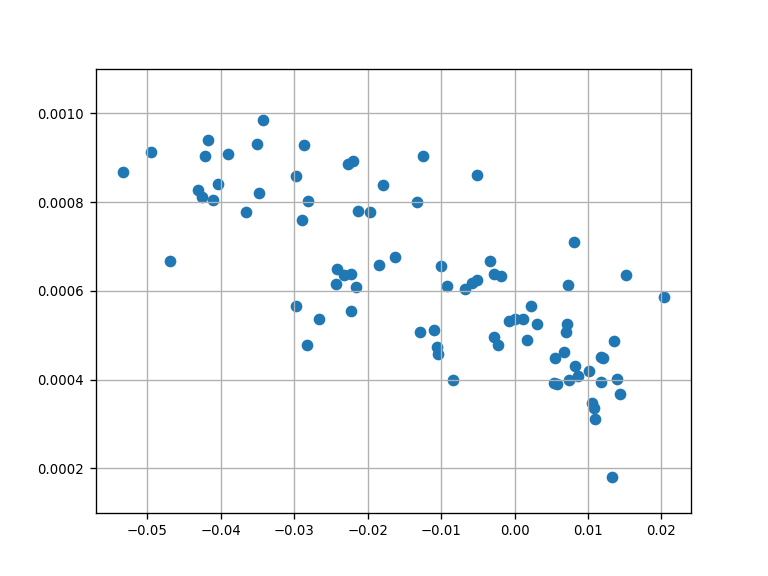

In [174]:

Temp = T30.resample('D').median()
plt.figure()
plt.scatter(Temp.NEE,Temp.NME)
plt.ylim(0.0001,0.0011)
plt.grid()
# plt.figure()
# # plt.bar(Temp.index.dayofyear,Temp['co2_flux']/Temp['NEE'])
# plt.bar(Temp.index.dayofyear,Temp['ch4_flux']/Temp['NME'])
# plt.grid()
# print(Day.sort_values()[-11:])

<IPython.core.display.Javascript object>


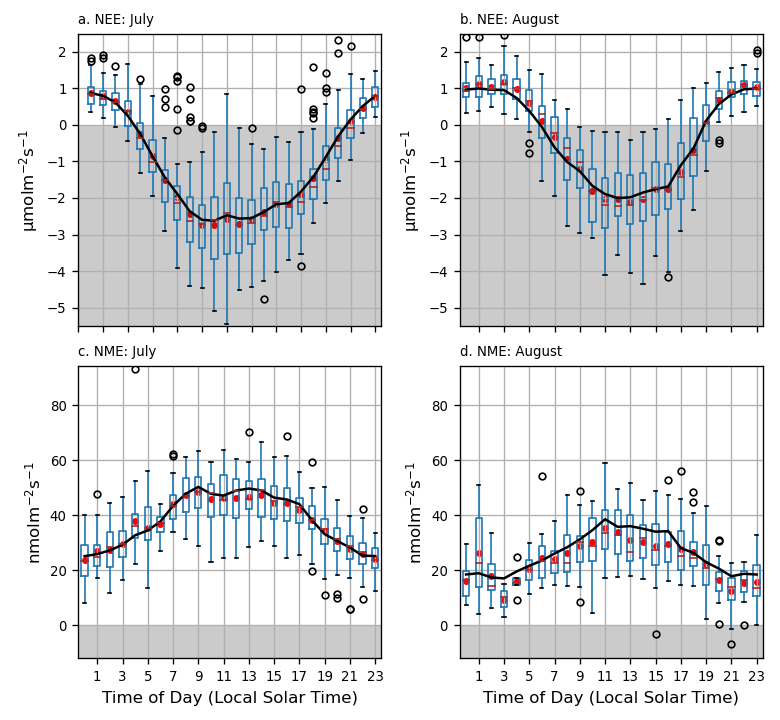

7
mean:  -1.11514914238677 38.09447082518502
max:  0.868267497206704 50.35599491208272
min:  -2.6214006587313485 25.14862835682395
Peak
[10]
[9]
Min
[0]
[0]
0.5080645161290323
31


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


mean:  -0.3800328506496457 25.9918982001369
max:  0.9913052490230719 38.5878012253419
min:  -2.0035722174961745 17.04199474214083
Peak
[12]
[11]
Min
[1]
[3]
0.49479068941880655 3.6615600720577106
11
0.27889784946236557


In [175]:

T30['Hour']=T30.index.hour-3
T30.loc[T30['Hour']<0,'Hour']+=24

fig,ax = plt.subplots(2,2,sharex=True,figsize=(6.5,6))
medianprops = dict(linestyle='-', linewidth=1, color='k')
T30['ch4_flux_scaled']=T30['ch4_flux']*1e3

flierprops = dict(markersize=4)
# Temp = T30.loc[((T30.DOY>=0) & (T30.DOY<207))]
Temp = T30.loc[T30.Month==7]
bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[0,0],medianprops = medianprops,flierprops=flierprops, return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[1,0],medianprops = medianprops,flierprops=flierprops, return_type='dict')


[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Hour = Temp.groupby('Hour').mean()

a1=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b1=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])

print(Hour.loc[Hour['NEE']>0].count()['NEE'])

print('mean: ',Hour['NEE'].mean()/mult['fco2'],Hour['NME'].mean()/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max()/mult['fco2'],Hour['NME'].max()/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min()/mult['fco2'],Hour['NME'].min()/mult['fco2']*1e3)



print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)

print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)

ax[0,0].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10)
ax[1,0].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10)
print(Temp['ch4_flux'].count()/Temp['NME'].count())
ax[0,0].plot(Hour.index+1,Hour['NEE']/mult['fco2'],color='k')
ax[1,0].plot(Hour.index+1,Hour['NME']/mult['fch4'],color='k')
yl1 = [T30['co2_flux'].min()+T30['co2_flux'].min()*.01,T30['co2_flux'].max()+T30['co2_flux'].max()*.01]#ax[0,0].get_ylim()
ax[0,0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.25)
ax[0,0].set_ylim(yl1[0],yl1[1])
yl2 = [T30['ch4_flux'].min()*1e3+T30['ch4_flux'].min()*1e3*.01,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.01]#ax[1,0].get_ylim()
ax[1,0].axhspan(yl2[0],0, facecolor='0.2', alpha=0.25)
ax[1,0].set_ylim(yl2[0],yl2[1])
ax[0,0].set_title('')
ax[1,0].set_title('')
ax[0,0].set_title('a. NEE: July',loc='left')
ax[1,0].set_title('c. NME: July',loc='left')
ax[0,0].set_xlabel('')
ax[1,0].set_xlabel('Time of Day (Local Solar Time)')
ax[0,0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1,0].set_ylabel('$nmol m^{-2} s^{-1}$')


# Temp = T30.loc[((T30.DOY>=207) & (T30.DOY<340))]
Temp = T30.loc[T30.Month==8]
print(Temp.resample('D').mean()['NEE'].count())

bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[0,1],medianprops = medianprops,flierprops=flierprops,return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[1,1],medianprops = medianprops,flierprops=flierprops,return_type='dict')
[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
# [[item.markersize(10) for item in bp0[key]['fliers']] for key in bp0.keys()]
# [[item.markersize(10) for item in bp1[key]['fliers']] for key in bp1.keys()]
# for key in bp1.keys():
#     print(bp1[key].keys())
Hour = Temp.groupby('Hour').mean()

a2=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b2=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])
print('mean: ',Hour['NEE'].mean()/mult['fco2'],Hour['NME'].mean()/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max()/mult['fco2'],Hour['NME'].max()/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min()/mult['fco2'],Hour['NME'].min()/mult['fco2']*1e3)


print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)

print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)

print(a1-a2,(b1-b2))

print(Hour.loc[Hour['NEE']>0].count()['NEE'])

ax[0,1].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10)
ax[1,1].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10)
print(Temp['ch4_flux'].count()/Temp['NME'].count())
ax[0,1].plot(Hour.index+1,Hour['NEE']/mult['fco2'],color='k')
ax[1,1].plot(Hour.index+1,Hour['NME']/mult['fch4'],color='k')
# yl = ax[0,1].get_ylim()
ax[0,1].axhspan(yl1[0],0, facecolor='0.2', alpha=0.25)
ax[0,1].set_ylim(yl1[0],yl1[1])
# yl = ax[1,1].get_ylim()
ax[1,1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.25)
ax[1,1].set_ylim(yl2[0],yl2[1])
ax[0,1].set_title('')
ax[1,1].set_title('')
ax[0,1].set_title('b. NEE: August',loc='left')
ax[1,1].set_title('d. NME: August',loc='left')
ax[0,1].set_xlabel('')
ax[1,1].set_xlabel('Time of Day (Local Solar Time)')
ax[0,1].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1,1].set_ylabel('$nmol m^{-2} s^{-1}$')


ax[0,0].set_xticks([x for x in range(0,25,2)])
# ax[0,1].set_xticks()
# ax[1,0].set_xticks([x for x in range(0,24,2)])
# ax[1,1].set_xticks([x for x in range(0,24,2)])
# ax[1,0].set_xticklabels([x for x in range(0,24,2)])

ax[1,1].set_xticklabels([x-1 for x in range(0,25,2)])


plt.suptitle('')
plt.tight_layout()

plt.savefig('Hourly.png',dpi = 400)
# print(T30[['Time','Hour']][0:100].values)


In [176]:

U = T30.loc[((T30.Month==7)&(T30.Hour>=10)&(T30.Hour<=17)),'ch4_flux'].median()
S = T30.loc[((T30.Month==8)&(T30.Hour>=0)&(T30.Hour<=24)),'ch4_flux'].std()
C = T30.loc[((T30.Month==8)&(T30.Hour>=0)&(T30.Hour<=24)),'ch4_flux'].count()
print(U*mult['fch4']*1e6*2)
# print(S/(C)**.5*stats.t.ppf(1-0.025,C)*mult['fch4']*1e6*2)
# Hour = Temp.groupby('Time').mean()
# Hour = Temp.groupby('Time').mean()
# print((Hour.loc[((Hour.index>=12)&(Hour.index<=17)),['ch4_flux']]*mult['fco2']*1e3).mean())#/mult['fch4'])

# print(29/44.01)
# print(35/44.01)

# print(Hour['ER_est'].max())

# print(1.11/mult['fco2']/48)

1.9939188635871654


<IPython.core.display.Javascript object>


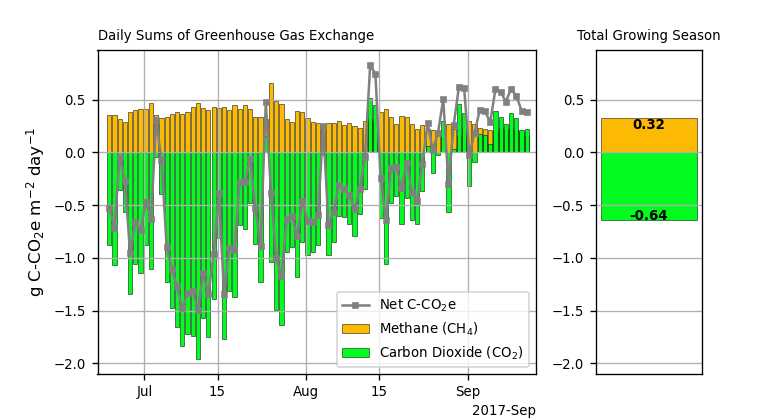

Bal:  -0.3170031744548972


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:74: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


2017-09-12 00:00:00-06:00


In [177]:
import matplotlib.gridspec as gridspec

import matplotlib.dates as mdates

Daily = T30.resample('D').mean()

Daily[['NEE','NME','Rain_mm_Tot']] = T30[['NEE','NME','Rain_mm_Tot']].resample('D').sum()
Daily['Recs'] = T30.resample('D').count()['NEE']
Daily = Daily.loc[Daily['Recs']>=48]

Color={'NEE':'#03fc20','NME':'#fcba03','ER_est':[.4,.4,.4],'GPP_est':[.8,.8,.8]}

# Daily = Daily.set_index('DOY')

# Daly = Daily.loc[Dal]
# fig,ax=plt.subplots(1,1)
# ax.bar(Daily.index,Daily['NME']/mult['fch4']*GWPmult['fch4'],color = Color['NME'],edgecolor='k',linewidth=.3)
# ax.bar(Daily.index,Daily['NEE']/mult['fco2']*GWPmult['fco2'],color = Color['NEE'],edgecolor='k',linewidth=.3)
# ax.grid()
# ax.bar(Daily.index,Daily['NEE']/mult['fco2']* 1e-6 * 44.01 *1800+Daily['NME']/mult['fch4']* 1e-3 * 1e-6 * 44.01 *1800*28)
fig2 = plt.figure(figsize=(6.5,3.5))#,constrained_layout=True)
spec2 = gridspec.GridSpec(ncols=22, nrows=1, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0:16])
f2_ax2 = fig2.add_subplot(spec2[0, 18:])
f2_ax1.bar(Daily.index,Daily['NME']/mult['fch4']*GWPmult['fch4'],color = Color['NME'],edgecolor='k',linewidth=.3,label='Methane (CH$_4$)')
f2_ax1.bar(Daily.index,Daily['NEE']/mult['fco2']*GWPmult['fco2'],color = Color['NEE'],edgecolor='k',linewidth=.3,label='Carbon Dioxide (CO$_2$)')


f2_ax1.plot(Daily.index,Daily['NME']/mult['fch4']*GWPmult['fch4']+Daily['NEE']/mult['fco2']*GWPmult['fco2'],
            color=[.5,.5,.5],marker='s',markersize=3,label='Net C-CO$_2$e')#,color = Color['NEE'],edgecolor='k',linewidth=.3,label='Carbon Dioxide (CO$_2$)')
# Total = 




f2_ax2.bar(1,T30['NEE'].mean()/mult['fco2']*GWPmult['fco2']*48,color=Color['NEE'],edgecolor='k',linewidth=.3)
f2_ax2.bar(1,T30['NME'].mean()/mult['fch4']*GWPmult['fch4']*48,color=Color['NME'],edgecolor='k',linewidth=.3)


print('Bal: ',T30['NEE'].mean()/mult['fco2']*GWPmult['fco2']*48+T30['NME'].mean()/mult['fch4']*GWPmult['fch4']*48)

f2_ax2.text(1,T30['NEE'].mean()/mult['fco2']*GWPmult['fco2']*48, str(np.round(T30['NEE'].mean()/mult['fco2']*GWPmult['fco2']*48,2)),
            color='k', fontweight='bold',ha='center',va='baseline')

f2_ax2.text(1,T30['NME'].mean()/mult['fch4']*GWPmult['fch4']*48, str(np.round(T30['NME'].mean()/mult['fch4']*GWPmult['fch4']*48,2)),
            color='k', fontweight='bold',ha='center',va='top')


f2_ax2.set_ylim(f2_ax1.get_ylim())
f2_ax2.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

f2_ax2.grid(axis='y')
f2_ax1.grid()#axis='y')


f2_ax1.set_xlim(datetime.datetime(2017,6,22),datetime.datetime(2017,9,14))
locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)
f2_ax1.xaxis.set_major_locator(locator)
f2_ax1.xaxis.set_major_formatter(formatter)

f2_ax1.set_title('Daily Sums of Greenhouse Gas Exchange',loc='left')
f2_ax2.set_title('Total Growing Season')
# f2_ax2.set
f2_ax1.set_ylabel('g C-CO$_2$e m$^{-2}$ day$^{-1}$')
f2_ax1.legend()
# ax.bar(Daily.index,Daily['NME']/mult['fch4']/1e3)
# f2_ax1.autofmt_xdate()
plt.tight_layout()
plt.savefig('GWP.png',dpi=300)
print(Daily.index.max())

<IPython.core.display.Javascript object>


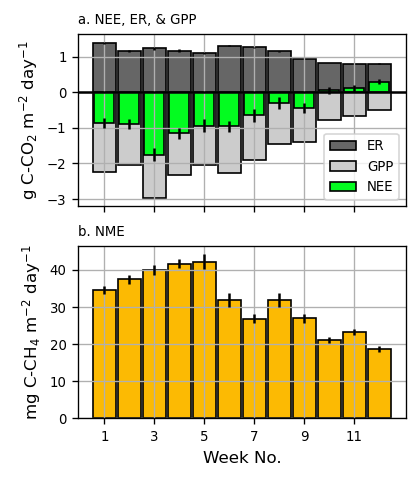

DatetimeIndex(['2017-06-29 00:00:00-06:00', '2017-07-06 00:00:00-06:00',
               '2017-07-13 00:00:00-06:00', '2017-07-20 00:00:00-06:00',
               '2017-07-27 00:00:00-06:00', '2017-08-03 00:00:00-06:00',
               '2017-08-10 00:00:00-06:00', '2017-08-17 00:00:00-06:00',
               '2017-08-24 00:00:00-06:00', '2017-08-31 00:00:00-06:00',
               '2017-09-07 00:00:00-06:00', '2017-09-14 00:00:00-06:00'],
              dtype='datetime64[ns, pytz.FixedOffset(-360)]', name='datetime', freq='W-THU')
NEE    0.291492
NME    0.042206
dtype: float64
NEE   -1.748801
NME    0.018709
dtype: float64


In [178]:
fig,ax=plt.subplots(2,1,sharex=True,figsize=(3.5,4))
ax[0].grid()
# print(T30.index[0:48])

Wgroup = 'W-Thu'
Weekly = T30.resample(Wgroup).mean()
Weekly_Std = T30.resample(Wgroup).std()
Weekly_Count = T30.resample(Wgroup).count()


print(Weekly.index)
Weekly = Weekly.reset_index()
Weekly_Std = Weekly_Std.reset_index()
Weekly_Count = Weekly_Count.reset_index(drop=True)

# Weekly=Weekly[1:]
# Weekly_Std=Weekly_Std[1:]
# Weekly_Count=Weekly_Count[1:]

ax[0].bar(Weekly.index+1,Weekly['ER_est'],
          yerr=Weekly_Std['ER_est']/Weekly_Count['ER_est']**.5*stats.t.ppf(1-.025,Weekly_Count['ER_est']),
          width=.9,edgecolor='k',color=Color['ER_est'],label='ER')

ax[0].bar(Weekly.index+1,Weekly['NEE']*48-Weekly['ER_est'],
          width=.9,edgecolor='k',color=Color['GPP_est'],label='GPP')

ax[0].bar(Weekly.index+1,Weekly['NEE']*48,
          yerr=Weekly_Std['NEE']*48/Weekly_Count['NME']**.5*stats.t.ppf(1-.025,Weekly_Count['NME']),
          width=.8,edgecolor='k',color=Color['NEE'],label='NEE')

ax[0].legend()


ax[1].bar(Weekly.index+1,Weekly['NME']*48*1e3,
          yerr=Weekly_Std['NME']*48*1e3/Weekly_Count['NME']**.5*stats.t.ppf(1-.025,Weekly_Count['NME']),
          width=.9,edgecolor='k',color=Color['NME'])
ax[1].grid()#/mult['fco2'])
# plt.plot(T30.resample('W').mean()['fco2'])

# Weekly = T30.resample(Wgroup).mean()
# Weekly_Std = T30.resample(Wgroup).std()
# Weekly_Count = T30.resample(Wgroup).count()


# ax[1].set_xlim(datetime.datetime(2017,6,22),datetime.datetime(2017,9,14))
# locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
# formatter = mdates.ConciseDateFormatter(locator)
# ax[1].xaxis.set_major_locator(locator)
# ax[1].xaxis.set_major_formatter(formatter)
ax[1].set_xticks([1,3,5,7,9,11])

ax[0].set_title('a. NEE, ER, & GPP',loc='left')
ax[1].set_title('b. NME',loc='left')


ax[0].set_ylabel('g C-CO$_2$ m$^{-2}$ day$^{-1}$')
ax[1].set_ylabel('mg C-CH$_4$ m$^{-2}$ day$^{-1}$')
ax[1].set_xlabel('Week No.')

al = ax[0].get_xlim()
ax[0].plot(al,[0,0],color='k')
ax[0].set_xlim(al)

plt.tight_layout()
plt.savefig('Weekly.png',dpi=300)

print(Weekly[['NEE','NME']].max()*48)
print(Weekly[['NEE','NME']].min()*48)



# print(Weekly_Count[['NEE','fco2','fch4']])
# print(Weekly[['NEE','NME']])
# print('Bal: ',Weekly['NEE'].mean()/mult['fco2']*GWPmult['fco2']*48,Weekly['NME'].mean()/mult['fch4']*GWPmult['fch4']*48)

<IPython.core.display.Javascript object>


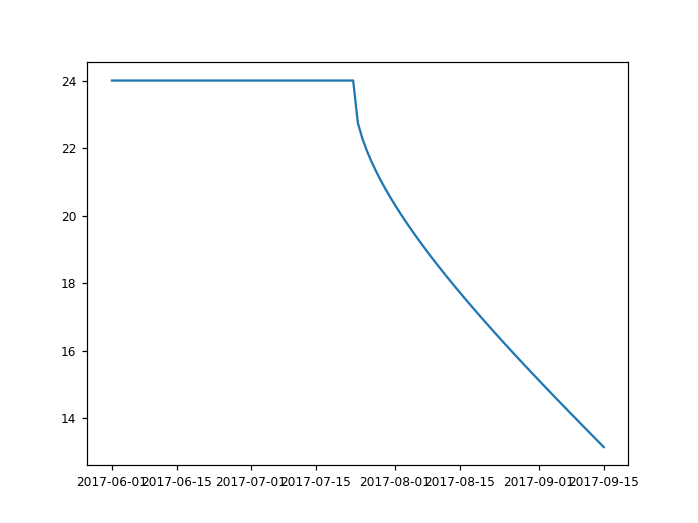

In [45]:
Sun = pd.read_csv('C:/FishIsland_2017/SolarPosition.csv')
# Sun=Sun.dropna()
# Sun.to_csv('C:/FishIsland_2017/SolarPosition.csv')
Sun = Sun.set_index(pd.to_datetime(Sun.Date))
# Sun['Time'] = pd.to_datetime(Sun.Daylength)
# Sun.plot()
# print(Sun['Daylength'])
plt.figure()
# # plt.plot(Sun['Time'])
plt.plot(Sun['Daylength'])

<IPython.core.display.Javascript object>


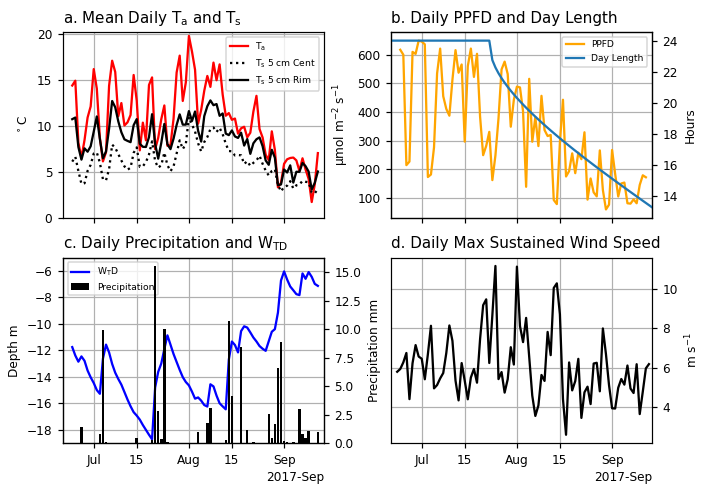

-0.6491099639975337
0.03295435837655307
-1.097940394546188
-1.0397625844854037
-24.191201528318267
                NME
datetime           
6         35.378542
7         40.312289
8         28.857747
9         22.755930


In [46]:
# fig = plt.figure(figsize=(6.5,7))

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Daily = T30.resample('D').mean()

fig,ax = plt.subplots(2,2,figsize=(6.5,4.5),sharex=True)

ax[1,0].set_title('c. Daily Precipitation and W$_{TD}$',loc='left')
ax[1,1].set_title('d. Daily Max Sustained Wind Speed',loc='left')
# ax[2,0].set_title('e.',loc='left')
ax[0,1].set_title('b. Daily PPFD and Day Length',loc='left')
ax[0,0].set_title('a. Mean Daily T$_{a}$ and T$_{s}$',loc='left')


# ax[2,1].grid()
ax[1,0].grid()
ax[1,1].grid()
# ax[2,0].grid()
ax[0,1].grid()
ax[0,0].grid()


# ax62=ax6.twinx()
ax[0,0].plot(Daily['AirTC_Avg'],color='r',label='T$_a$')
ax[0,0].set_ylabel('$^\circ$C')
ax[0,0].plot(Daily['Temp_5_1'],color='k',label='T$_s$ 5 cm Cent',linestyle=':')
ax[0,0].plot(Daily['Temp_5_2'],color='k',label='T$_s$ 5 cm Rim')
ax[0,0].legend()


# ax[1,1].plot(T30['wind_speed'].resample('D').max(),color='k',label='Sustained')
# ax[1,1].plot(T30['max_wind_speed'].resample('D').max(),color='k',label='Gust')
ax[1,1].plot(T30['wind_speed'].resample('D').max(),color='k',label='Sustained')


ax[1,1].set_ylabel('m s$^{-1}$')
ax[0,0].set_ylim(0,20.2)
# ax[0,0].legend(ncol=3)

ax[0,1].plot(Daily['PPFD_Avg'],color='orange',label='PPFD')
ax[0,1].set_ylabel('$\mu$mol m$^{-2}$ s$^{-1}$')
ax2 = ax[0,1].twinx()
ax[0,1].plot(Sun['Daylength']*np.nan,label='Day Length')
ax2.plot(Sun['Daylength'])
ax2.set_ylabel('Hours')
ax[0,1].legend()
# ax[0,1].yaxis.set_label_position("right")
# ax[0,1].yaxis.tick_right()



# ax2 = ax[1,1].twinx()
ax[1,0].plot(Daily['Table_1']*100,color='blue',label='W${_TD}$')
ax[1,0].set_ylabel('Depth m')
ax[1,0].set_ylim(-19,-5)

ax2=ax[1,0].twinx()
# T30['TotalRai']
# Daly['Rain']=T30['Rain_mm_Tot'].resample('D').sum()
ax2.bar(Daily.index,Daily['Rain_mm_Tot'],color='k')
ax[1,0].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,color='k',label='Precipitation')
ax2.set_ylabel('Precipitation mm')
ax[1,0].legend()


ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()


ax[0,1].set_xlim(datetime.datetime(2017,6,21),datetime.datetime(2017,9,14))
ax[1,0].set_xlim(datetime.datetime(2017,6,21),datetime.datetime(2017,9,14))

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%m/%d')

locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
formatter = mdates.ConciseDateFormatter(locator)


ax[0,1].xaxis.set_major_locator(locator)
ax[1,0].xaxis.set_major_locator(locator)

ax[0,1].xaxis.set_major_formatter(formatter)
ax[1,0].xaxis.set_major_formatter(formatter)

# fig.autofmt_xdate()



print(Daily['NEE'].mean())
print(Daily['NME'].mean())

print(Daily['CBal'].cumsum().min())
print(Daily['CBal'].cumsum()[-1])

print(Daily.loc[((Daily['DOY']>=200)&(Daily['DOY']<=235)),'NEE'].sum())
print(T30[['NME']].groupby(T30.index.month).mean()*1e3*48)
plt.tight_layout()
plt.savefig('Conditions.png',dpi = 400)

<IPython.core.display.Javascript object>


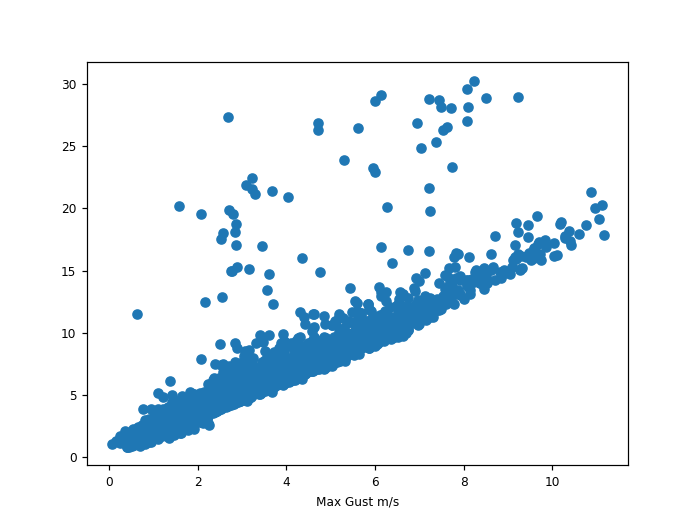

Text(0.5, 0, 'Max Gust m/s')

In [47]:
plt.figure()
plt.scatter(T30['wind_speed'],T30['max_wind_speed'])
plt.xlabel('Half Hourly Average m/s')
plt.xlabel('Max Gust m/s')

<IPython.core.display.Javascript object>


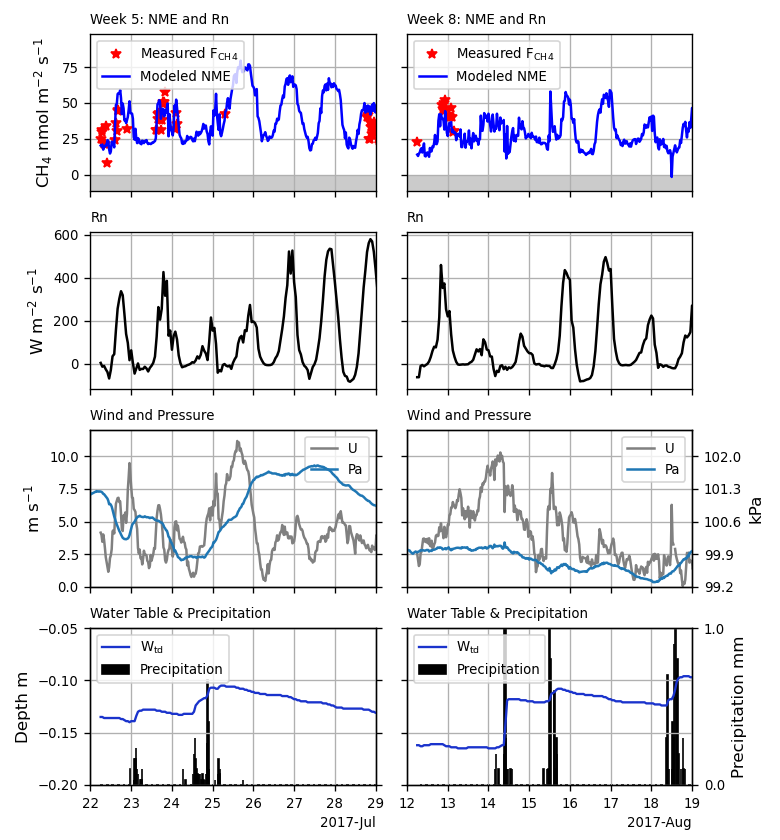

20.023514859175123
[ 99.24736255  99.93943775 100.63151296 101.32358816 102.01566336
 102.70773856]
0.03500000000000002
29.16259268412138
[ 99.24736255  99.93943775 100.63151296 101.32358816 102.01566336
 102.70773856]
0.06900000000000005
0.3743641912512716
30.3002839257616
                                NME   ch4_flux
datetime                                      
2017-07-15 07:30:00-06:00  1.580688  93.368189


In [180]:
Lims = [
#     2017-07-28 
[datetime.datetime(2017,7,22,0), datetime.datetime(2017,7,29,0)],
[datetime.datetime(2017,8,12,0), datetime.datetime(2017,8,19,0)],
# [datetime.datetime(2017, 7, 29), datetime.datetime(2017, 8, 1)]
       ]
Names = ['Week 5: NME and Rn','Week 8: NME and Rn']

fig,ax=plt.subplots(4,2,figsize=(6.5,7),sharex='col',sharey='row')
i = -1

import matplotlib.ticker
nticks = 4
for Lim,Name in zip(Lims,Names):
    i+=1
    Temp = T30.loc[(T30.index.tz_localize(None)>=Lim[0]) & (T30.index.tz_localize(None)<Lim[1])]
    print(Temp['max_wind_speed'].max())

    ax[0,i].plot(Temp['ch4_flux']*1e3,color='r',marker='*',linewidth=0,label='Measured F$_{CH4}$')
    ax[0,i].plot(Temp['NME_est'],color='b',label='Modeled NME')
#     ax[0,i].set_zorder(x2.get_zorder()+1) # put ax in front of ax2
    ax[0,i].patch.set_visible(False) # hide the 'canvas'

    
    ax[0,i].set_xlim(Lim[0],Lim[1])
    ax[0,i].set_ylim(T30['ch4_flux'].min()*1e3-T30['ch4_flux'].min()*1e3*.05,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.05)
    ax[0,i].legend(loc=2)

    ax[0,i].set_title(Name,loc='left')
    ax[0,i].grid()
    ax[0,i].axhspan(yl2[0],0, facecolor='0.2', alpha=0.25)
#     ax2.set_ylim(-100,650)
    l = ax[0,i].get_ylim()
    l2 = ax2.get_ylim()
#     f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
#     ticks = f(ax[0,i].get_yticks())
#     ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))   
#     ax2.set_yticklabels(np.round(ax2.get_yticks(),0))
    if i == 0:
        ax[0,i].set_ylabel('CH$_4$ nmol m$^{-2}$ s$^{-1}$')
#         ax2.set_yticklabels([])
#     else:
#         ax2.set_ylabel('W m$^{-2}$ s$^{-1}$')
    
    
    ax[1,i].plot(Temp.resample('H').mean()['NR_Wm2_Avg'],color='k',label='Rn')
#     ax2.set_ylim(T30['NR_Wm2_Avg'].min(),T30['NR_Wm2_Avg'].max())
    if i == 0:
        ax[1,i].set_ylabel('W m$^{-2}$ s$^{-1}$')
    ax[1,i].set_title('Rn',loc='left')
    ax[1,i].grid()
    
    
    

    ax[2,i].plot(Temp['wind_speed'],color='grey',label='U')
    ax[2,i].set_ylim(0,12)
    ax[2,i].plot(T30['air_pressure']*np.nan,label='Pa')
    ax2=ax[2,i].twinx()
    ax2.plot(T30['air_pressure']*1e-3,label='Pa')
    ax2.set_ylim(T30['air_pressure'].min()*1e-3-T30['air_pressure'].min()*1e-3*.001,T30['air_pressure'].max()*1e-3+T30['air_pressure'].max()*1e-3*.001)
    ax[2,i].legend()
    ax[2,i].set_xlim(Lim[0],Lim[1])
    ax[2,i].set_title('Wind and Pressure',loc='left')
    ax[2,i].grid()

    l = ax[2,i].get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax[2,i].get_yticks())
    print(ticks)
    ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
    ax2.set_yticklabels(np.round(ax2.get_yticks(),1))
    
    if i == 0:
        ax[2,i].set_ylabel('m s$^{-1}$')
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel('kPa')
    
    

    ax[3,i].plot(Temp['Table_1'],label='W$_{td}$',color=[.1,.2,.8],linewidth=1.4)
    ax[3,i].set_ylim(-.2,-.05)
    ax2=ax[3,i].twinx()
    ax2.bar(Temp.index,Temp['Rain_mm_Tot'],color='k',label='Precipitation',width=.01,edgecolor='k')
    ax2.set_ylim(T30['Rain_mm_Tot'].min(),3)
    ax[3,i].bar(Temp.index,Temp['Rain_mm_Tot']*np.nan,color='k',label='Precipitation',width=.0,edgecolor='k')
    ax[3,i].legend(loc=2)
    ax[3,i].set_xlim(Lim[0],Lim[1])
    ax[3,i].set_title('Water Table & Precipitation',loc='left')
    ax[3,i].set_zorder(ax2.get_zorder()+1) # put ax in front of ax2 
    
    locator = mdates.AutoDateLocator(minticks=3, maxticks=8)
    formatter = mdates.ConciseDateFormatter(locator)
    ax[3,i].xaxis.set_major_locator(locator)
    ax[3,i].xaxis.set_major_formatter(formatter)
    ax[3,i].patch.set_visible(False) 
    ax[3,i].grid()
    print(Temp['Table_1'].max()-Temp['Table_1'].min())

    

    l = ax[3,i].get_ylim()
    l2 = ax2.get_ylim()
    f = lambda x : l2[0]+(x-l[0])/(l[1]-l[0])*(l2[1]-l2[0])
    ticks = f(ax[3,i].get_yticks())
    ax2.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(ticks))
    ax2.set_yticklabels(np.round(ax2.get_yticks(),1))
    
    if i == 0:
        ax[3,i].set_ylabel('Depth m')
        ax2.set_yticklabels([])
    else:
        ax2.set_ylabel('Precipitation mm')
# ax[0,0].set_xlim(Lims[0][0],Lims[0][1])
# ax[0,1].set_xlim(Lims[0][0],Lims[0][1])
plt.tight_layout()
#     plt.suptitle('Case '+str(i+1))
plt.savefig('CaseStudies.png')
print(T30.loc[np.isnan(T30['ch4_flux'])==False,'fch4'].count()/T30['NME'].count())
# print(T30.loc[np.isnan(T30['co2_flux'])==False,'fco2'].count()/T30['NME'].count())
print(T30['max_wind_speed'].max())
print(T30.loc[T30['ch4_flux']==T30['ch4_flux'].max(),['NME','ch4_flux']]*1e3)

<IPython.core.display.Javascript object>


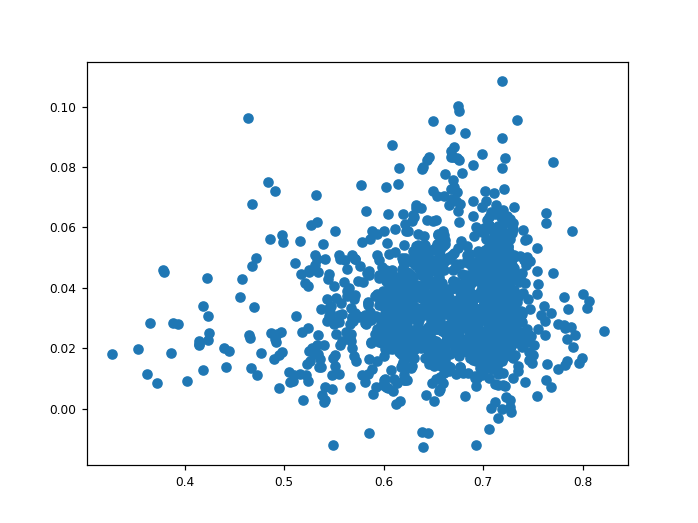

                AirTC_Avg       VPD        u*  wind_speed  air_pressure  \
AirTC_Avg        1.000000  0.808242  0.122661    0.088318      0.017543   
VPD              0.808242  1.000000  0.181591    0.156738      0.112160   
u*               0.122661  0.181591  1.000000    0.963125      0.095514   
wind_speed       0.088318  0.156738  0.963125    1.000000      0.052008   
air_pressure     0.017543  0.112160  0.095514    0.052008      1.000000   
NR_Wm2_Avg       0.533733  0.623297  0.311254    0.245323      0.168812   
PPFD_Avg         0.576188  0.662297  0.322605    0.258572      0.193351   
Table_1         -0.545407 -0.347534 -0.196708   -0.162201     -0.254147   
VWC_2           -0.533123 -0.301251 -0.107755   -0.085764     -0.258487   
VWC_1           -0.454962 -0.217506 -0.091655   -0.079599      0.015342   
Active_Layer_1  -0.418013 -0.299374 -0.243280   -0.223120     -0.392880   
Active_Layer_2  -0.396293 -0.289189 -0.244068   -0.223976     -0.394618   
Temp_2_5_1       0.641267

In [63]:
# print(T30.columns.values)
plt.figure()
plt.scatter(T30['Polygon'],T30['ch4_flux'])
print(T30[['AirTC_Avg', 'VPD', 'u*', 'wind_speed', 'air_pressure', 'NR_Wm2_Avg', 'PPFD_Avg', 'Table_1', 'VWC_2', 'VWC_1', 'Active_Layer_1', 'Active_Layer_2', 'Temp_2_5_1', 'Temp_5_1', 'Temp_15_1', 'Temp_2_5_2', 'Temp_5_2', 'Temp_15_2', 'Rim', 'Collapse', 'Polygon', 'Time', 'DOY']].corr())

# Mapping Taglu data. don't delete!

In [ ]:
fch4_Taglu = ResultMap('fch4',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')
fco2_Taglu = ResultMap('fco2',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')

print(fch4_Taglu.Model_Selection)
print(fco2_Taglu.Model_Selection)

In [ ]:
Taglu = pd.read_csv('C:\\Users\\wesle\\NetworkAnalysis/FishIsland//TagluRecord.csv')
Taglu['fco2']=np.nan
Taglu['fch4']=np.nan
Taglu.head()
Taglu = Taglu.set_index(pd.DatetimeIndex(Taglu.TIMESTAMP))
Taglu = Taglu.loc[pd.isnull(Taglu.index)==False]
Taglu = Taglu.loc[(Taglu.index.year>2008)&(Taglu.index.year<2019)]
Taglu.loc[Taglu['SoilMoist(4)']<20,'SoilMoist(4)']=np.nan
Taglu['Temp'] = Taglu['SoilMoist(4)'].interpolate()


In [ ]:

Taglu = Mapper(Taglu,fch4_Taglu,'NME_est',Fill = False)
Taglu = Mapper(Taglu,fco2_Taglu,'NEE_est',Fill = False)
print('Done')

In [ ]:
# print(Taglu.head())#[['NME_Est','NEE_Est']].mean())
Taglu['Month']=Taglu.index.month.values
Taglu = Taglu.loc[((Taglu.Month>5) & (Taglu.Month<10))]
# print(Taglu.head())

print(Taglu[['NEE_est','NME_est']].mean())

Yearly = (Taglu.groupby(Taglu.index.year).mean())
print(Yearly[['NEE_est','NME_est']])


Monthly = (Taglu.groupby('Month').mean())
print(Monthly[['NEE_est','NME_est']])
plt.figure()
plt.plot(Taglu['NEE_est'].resample('Y').mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].resample('Y').mean(),color='r')


plt.figure()
plt.plot(Taglu['NEE_est'].groupby(Taglu.index.dayofyear).mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].groupby(Taglu.index.dayofyear).mean(),color='r')

In [ ]:
plt.figure()
plt.scatter(Taglu['WindSpd'],Taglu['NME_est'])
# plt.plot(Taglu['NME_est'])

In [ ]:
# plt.figure()
# Temp = Taglu.loc[Taglu.Month==8]
# plt.scatter(Temp['SoilMoist(2)'],Temp['SoilMoist(4)'])
# # plt.plot(Taglu['SoilMoist(1)'].resample('Y').count())

In [ ]:
y=2015
fig=plt.figure()
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(4)']])
# plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(1)']])
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(2)']])
x2 = plt.twinx()
plt.plot(Taglu.loc[Taglu.index.year==y].Rainfall_Tot.cumsum())
# plt.plot(Taglu.loc[Taglu.index.year==y,['NME_est']])
fig.autofmt_xdate()